# Importing all the necessary libraries

In [15]:
# basic libraries
import copy
import os
import threading
import time
from lib2to3.pgen2.tokenize import tokenize

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers

# libraries for the model training and dataset loading
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from transformers import get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader

# LoRA library from Microsoft (https://github.com/microsoft/LoRA/tree/main)
import loralib

# files with custom Bert model and the changed file from transformers library
import bert_multi_lora
from custom_model import CustomBert, LoRABert

In [16]:
# uncomment the below line if you want to automatically reload the modules
# though this will disable debugging in the notebook

# %load_ext autoreload
# %autoreload 2

In [17]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [18]:
model_name = "google-bert/bert-base-uncased"

# model is initialized from the custom file since it has the masking functionality
bert = bert_multi_lora.BertModel.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Sizes comparison

In this section we compare the sizes of the custom implementation of the model with multiple adapters, and the [LoRA implementation from Microsoft](https://github.com/microsoft/LoRA/tree/main). The sizes are compared for the model with different number of adapters.

In [23]:
def get_size_of_model(model):
    """
    Function to get the size of the model. It calculates the size by adding all the parameters and buffers of the model.
    
    :param model: model for which the size is to be calculated 
    :return: size of the model in MB
    """
    param_size = 0
    for name, param in model.named_parameters():
        if "adapter" in name:
            param_size += param.nelement() * param.element_size()
    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    
    return (param_size) / 1024**2

def get_sizes(max_adapters=5):
    """
    Function to get the sizes of the models with different number of adapters.
    
    :param max_adapters: maximum number of adapters to be considered
    :return: 2 dataframes: on with the size of the model with custom adapters and the other with the size of the model with LoRA adapters
    """
    sizes = []
    sizes_full = []
    
    # sizes.append({"model": "bert", "size": get_size_of_model(bert)})
    sizes_full.append({"model": "bert", "size": get_size_of_model(bert)})
    
    for i in range(1, max_adapters + 1):
        model_custom = CustomBert(copy.deepcopy(bert), num_adapters=i)
        models_LoRA = [LoRABert(copy.deepcopy(bert)) for _ in range(i)]
        
        string = "adapter" if i == 1 else "adapters"
        sizes.append({"model": f"{i} {string}", "size": get_size_of_model(model_custom)})
        sizes_full.append({"model": f"{i} {string}", "size": sum([get_size_of_model(model) for model in models_LoRA])})
        
    return pd.DataFrame(sizes), pd.DataFrame(sizes_full)

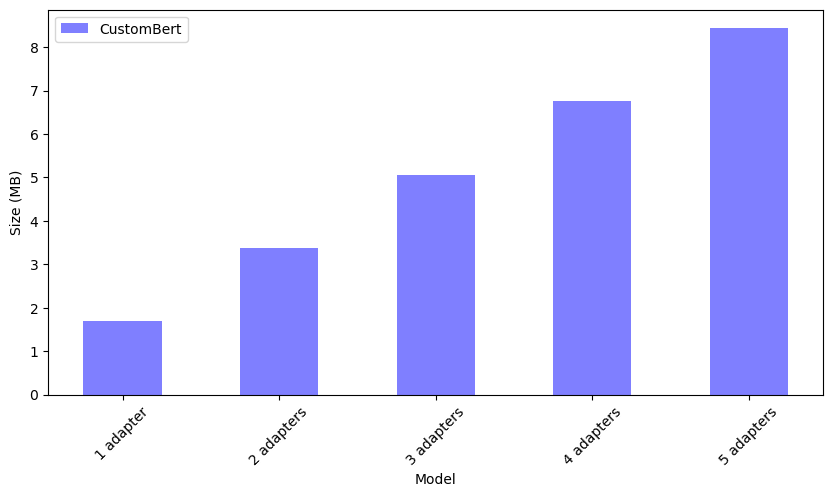

In [24]:
def plot_sizes(df_1, df_2):
    """
    Function to plot the sizes of the models with different number of adapters.
    
    :param df_1: dataframe with the sizes of the model with custom adapters
    :param df_2: dataframe with the sizes of the model with LoRA adapters
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    index = np.arange(len(df_1))
    bar_width = 0.5

    opacity = 0.5

    ax.bar(index, df_1["size"], bar_width, alpha=opacity, color='b', label='CustomBert')
    # ax.bar(index + bar_width, df_2["size"], bar_width, alpha=opacity, color='r', label='LoRABert')

    ax.legend()
    ax.set_ylabel("Size (MB)")
    ax.set_xlabel("Model")
    # ax.set_xticks(index + bar_width / 2)
    ax.set_xticks(index)
    ax.set_xticklabels(df_1["model"], rotation=45)
    plt.show()
    
df_custom, df_LoRA = get_sizes(5)    
plot_sizes(df_custom, df_LoRA)

As we can see from the plot above, the size of the model with custom adapters is significantly smaller than the size of the model with LoRA adapters. This is because the custom implementation only adds the adapters to the model, while the LoRA implementation adds the full model for each adapter.